# Etude de sélection de variables

In [72]:
# récupération des librairies
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso, lasso_path, LassoCV

In [6]:
# récupération du jeu de données sauvegardé
df = pd.read_csv('weatherAUS_preprocessed.csv', index_col=0)
df.head()

,MaxTemp,Rainfall,Sunshine,WindGustSpeed,Humidity3pm,Pressure9am,Cloud3pm,Temp3pm,RainToday,RainTomorrow,Temp_Delta_MinMax,Humidity_Delta,clim_chaud_humide,clim_méditerranéen,clim_sec,clim_tempéré_froid
0,22.9,0.6,0.15000,44.0,22.0,1007.7,8.00000,21.8,0,0,9.5,-49.0,1,0,0,0
1,25.1,0.0,7.63054,44.0,25.0,1010.6,4.49925,24.3,0,0,17.7,-19.0,1,0,0,0
2,25.7,0.0,11.70000,46.0,30.0,1007.6,2.00000,23.2,0,0,12.8,-8.0,1,0,0,0
3,28.0,0.0,7.63054,24.0,16.0,1017.6,4.49925,26.5,0,0,18.8,-29.0,1,0,0,0
4,32.3,1.0,2.55000,41.0,33.0,1010.8,8.00000,29.7,0,0,14.8,-49.0,1,0,0,0


In [7]:
# normalisation de l'ensemble des données
df_copy = df.copy()
df_copy[df_copy.columns] = pd.DataFrame(StandardScaler().fit_transform(df_copy))

In [8]:
# séparation des données en une matrice de données et en un vecteur cible
data = df_copy.drop(columns=['RainTomorrow'])
target = df_copy['RainTomorrow']

In [12]:
# division des données en un ensemble d'entraînement et un ensemble de test correspondant respectivement à 80% et 20% de la quantité totale des données disponibles
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.2, random_state=123)

In [13]:
y_train

71436     1.874102
16613    -0.533589
35841    -0.533589
109966   -0.533589
115370   -0.533589
            ...   
129130   -0.533589
119906   -0.533589
17730    -0.533589
28030    -0.533589
15725    -0.533589
Name: RainTomorrow, Length: 112629, dtype: float64

## Régression Ridge

In [18]:
# création d'un modèle de régression Ridge et ajustement sur données d'apprentissage
ridge_reg = RidgeCV(alphas=np.linspace(0.001, 1, 10))
ridge_reg.fit(X_train, y_train)

RidgeCV(alphas=array([0.001, 0.112, 0.223, 0.334, 0.445, 0.556, 0.667, 0.778, 0.889,
       1.   ]))

In [19]:
# alpha retenu par le modèle et scores du modèle sur l'ensemble d'entraînement et de test
print("alpha retenu par le modèle: ", ridge_reg.alpha_, "\n")

print("score du modèle sur l'ensemble d'entraînement: ", ridge_reg.score(X_train, y_train))
print("score du modèle sur l'ensemble de test: ", ridge_reg.score(X_test, y_test))

alpha retenu par le modèle:  1.0 

score du modèle sur l'ensemble d'entraînement:  0.30183189857514814
score du modèle sur l'ensemble de test:  0.30745713102657257


In [22]:
# calcul des erreurs quadratique moyenne de prédiction
ridge_pred_train = ridge_reg.predict(X_train)
ridge_pred_test = ridge_reg.predict(X_test)

mse_train = mean_squared_error(y_train, ridge_pred_train)
mse_test = mean_squared_error(y_test, ridge_pred_test)

print("Erreur quadratique moyenne de prédiction pour ridge_pred_train: ", mse_train)
print("Erreur quadratique moyenne de prédiction pour ridge_pred_test: ", mse_test)

Erreur quadratique moyenne de prédiction pour ridge_pred_train:  0.69905444355994
Erreur quadratique moyenne de prédiction pour ridge_pred_test:  0.6890137198872469


## Régression Lasso

In [33]:
# création d'un modèle de régression Lasso et ajustement sur données d'apprentissage
lasso_reg = Lasso(alpha=0.01)
lasso_reg.fit(X_train, y_train)

Lasso(alpha=0.01)

In [34]:
# coefficients estimés par le modèle
print("Coefficients estimés par le modèle: ", lasso_reg.coef_)

Coefficients estimés par le modèle:  [ 0.          0.11085993 -0.14314188  0.1521531   0.35608471 -0.12854251
  0.01647745  0.00233129  0.          0.04957764  0.         -0.
  0.010464    0.01841912 -0.04035516]


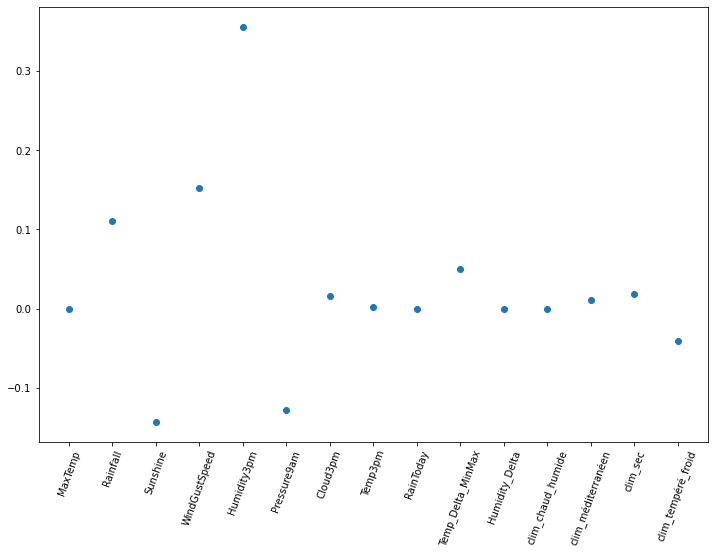

In [38]:
# graphique représentant la valeur estimée du coefficient pour chaque variable de data 
fig = plt.figure(figsize=(12,8))
plt.plot(range(len(data.columns)), lasso_reg.coef_, "o")
plt.xticks(range(len(data.columns)), data.columns.values, rotation=70);

- 10 variables sur 12 ont été sélectionnées par le modèle, avec le paramètre "alpha = 0.01". 
- Les coefficients des 2 autres variables sont estimés à 0.

In [39]:
# scores du modèle sur l'ensemble d'apprentissage et l'ensemble de test
print("Score du modèle sur l'ensemble d'apprentissage: ", lasso_reg.score(X_train, y_train))
print("Score du modèle sur l'ensemble de test: ", lasso_reg.score(X_test, y_test))

Score du modèle sur l'ensemble d'apprentissage:  0.2997084093093404
Score du modèle sur l'ensemble de test:  0.30626955235235587


In [40]:
# calcul des erreurs quadratique moyenne de prédiction
lasso_pred_train = lasso_reg.predict(X_train)
lasso_pred_test = lasso_reg.predict(X_test)

mse_train = mean_squared_error(y_train, lasso_pred_train)
mse_test = mean_squared_error(y_test, lasso_pred_test)

print("Erreur quadratique moyenne de prédiction pour lasso_pred_train: ", mse_train)
print("Erreur quadratique moyenne de prédiction pour lasso_pred_test: ", mse_test)

Erreur quadratique moyenne de prédiction pour lasso_pred_train:  0.7011806286492976
Erreur quadratique moyenne de prédiction pour lasso_pred_test:  0.690195246745207


In [43]:
# calcul des coefficients estimés en fonction des valeurs prises par alpha
alphas = (0.001, 0.01, 0.02, 0.025, 0.05, 0.1, 0.25, 0.5, 0.8, 1.0)
alphas = np.linspace(0.001, 1, 10)
alpha_path, coefs_lasso, _ = lasso_path(X_train, y_train, alphas=alphas)
coefs_lasso.shape

(15, 10)

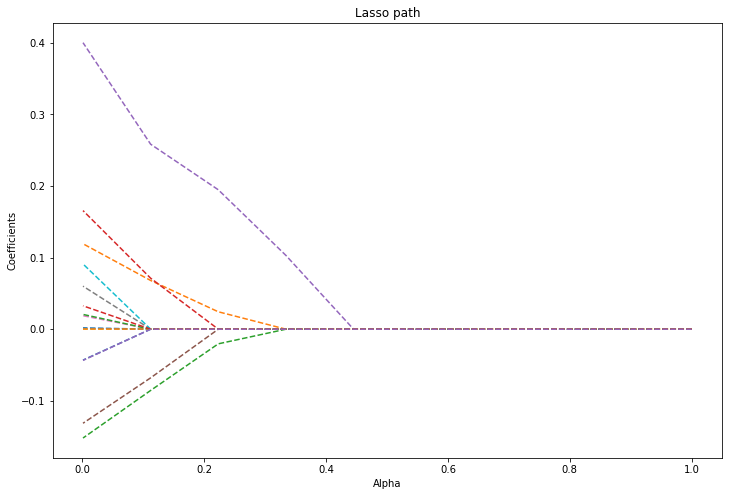

In [44]:
# courbe des valeurs du coefficient estimé en fonction des valeurs prises par alpha
fig = plt.figure(figsize=(12,8))
for i in range(coefs_lasso.shape[0]):
  plt.plot(alpha_path, coefs_lasso[i,:],'--')
plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.title('Lasso path');

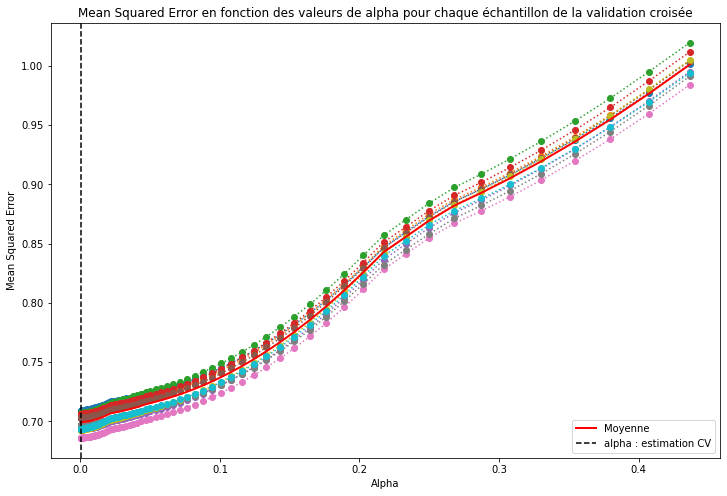

In [47]:
# recherche du alpha optimal en fonction de la performance prédictive, par validation croisée
model_lasso = LassoCV(cv=10)
model_lasso.fit(X_train, y_train)

alphas = model_lasso.alphas_

fig = plt.figure(figsize=(12,8))
plt.plot(alphas, model_lasso.mse_path_, 'o:')
plt.plot(alphas, model_lasso.mse_path_.mean(axis=1), 'r', label='Moyenne', linewidth=2)
plt.axvline(model_lasso.alpha_, linestyle='--', color='k', label='alpha : estimation CV')
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error en fonction des valeurs de alpha pour chaque échantillon de la validation croisée')
plt.legend();

In [48]:
# score et MSE obtenu sur l'echantillon de test par le modèle 'model_lasso'
print("score du modèle sur l'ensemble d'apprentissage: ", model_lasso.score(X_train, y_train)) 
print("score du modèle sur l'ensemble de test: ", model_lasso.score(X_test, y_test))

model_lasso_pred_train = model_lasso.predict(X_train)
model_lasso_pred_test = model_lasso.predict(X_test)

mse_train = mean_squared_error(y_train, model_lasso_pred_train)
mse_test = mean_squared_error(y_test, model_lasso_pred_test)

print("\n Erreur quadratique moyenne de prédiction pour model_lasso_pred_train: ", mse_train)
print("Erreur quadratique moyenne de prédiction pour model_lasso_pred_test: ", mse_test)

score du modèle sur l'ensemble d'apprentissage:  0.3017985258137237
score du modèle sur l'ensemble de test:  0.3075387419054014

 Erreur quadratique moyenne de prédiction pour model_lasso_pred_train:  0.6990878586889325
Erreur quadratique moyenne de prédiction pour model_lasso_pred_test:  0.6889325248916384


## Embedded Method

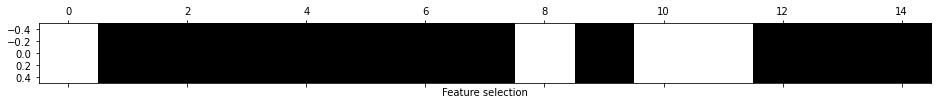

In [55]:
# ajustement du selecteur sur le jeu d'entraînement 
lasso = Lasso(alpha=0.01)
sel = SelectFromModel(estimator=lasso, threshold=1e-10)
sel.fit(X_train, y_train)

# représentation graphique des features sélectionnées 
mask = sel.get_support()
plt.matshow(mask.reshape(1,-1), cmap='gray_r')
plt.xlabel('Feature selection');

In [60]:
# création d'une grille de paramètres pour alpha et ajustement de la grid search sur le jeu d'entraînement
alpha_grid = {'alpha' : np.linspace(0.001, 1, 10)}
crossval  = KFold(n_splits=3, random_state=2, shuffle=True)

search = GridSearchCV(estimator=lasso, param_grid=alpha_grid, scoring='neg_mean_squared_error', cv=crossval)
search.fit(X_train, y_train)
print("Meilleur paramètre retenu par la grid search: ", search.best_params_)

Meilleur paramètre retenu par la grid search:  {'alpha': 0.001}


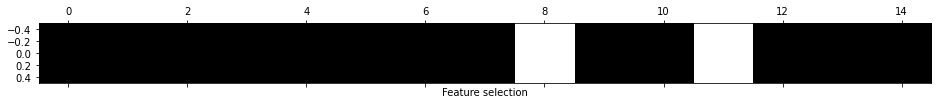

In [61]:
# récupération du jeu de features sélectionnées
sel = SelectFromModel(estimator=search.best_estimator_, threshold=1e-10, prefit=True)

# représentation graphique des features sélectionnées 
mask = sel.get_support()
plt.matshow(mask.reshape(1,-1), cmap='gray_r')
plt.xlabel('Feature selection');

In [62]:
#création de la liste des variables sélectionnées
select_feats = []
for feats, select in zip(X_train.columns, mask):
    if select == True:
        select_feats.append(feats)

In [63]:
# select_feats = X_train.columns[mask]
X_train.columns[mask]

Index(['MaxTemp', 'Rainfall', 'Sunshine', 'WindGustSpeed', 'Humidity3pm',
       'Pressure9am', 'Cloud3pm', 'Temp3pm', 'Temp_Delta_MinMax',
       'Humidity_Delta', 'clim_méditerranéen', 'clim_sec',
       'clim_tempéré_froid'],
      dtype='object')

# Sélection de variables avec SelectKBest

In [69]:
df = pd.read_csv("weatherAUS_Rev0.csv", index_col=0)
df_copy = df.copy()
# séparation des données en une matrice de données et en un vecteur cible
data = df_copy.drop(columns=['RainTomorrow'])
target = df_copy['RainTomorrow']
# division des données en un ensemble d'entraînement et un ensemble de test correspondant respectivement à 80% et 20% de la quantité totale des données disponibles
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.2, random_state=123)

In [70]:
# SelectKBest nécessite des données positives pour le chi2
X_Kbest = pd.DataFrame(MinMaxScaler().fit_transform(X_train), columns=X_train.columns)

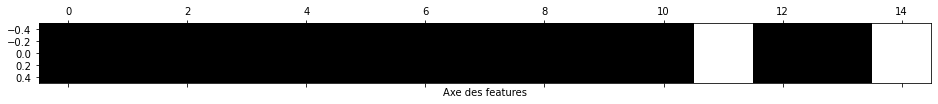

In [73]:
sel = SelectKBest(score_func = chi2, k=13)
sel.fit(X_Kbest, y_train)
mask = sel.get_support()
plt.matshow(mask.reshape(1,-1), cmap = 'gray_r')
plt.xlabel('Axe des features');

In [74]:
select_feats = X_train.columns[mask]
X_train.columns[mask]

Index(['MaxTemp', 'Rainfall', 'Sunshine', 'WindGustSpeed', 'Humidity3pm',
       'Pressure9am', 'Cloud3pm', 'Temp3pm', 'RainToday', 'Temp_Delta_MinMax',
       'Humidity_Delta', 'clim_méditerranéen', 'clim_sec'],
      dtype='object')